In [1]:
import pandas as pd
import xarray as xr
import glob  
import glob
import feather 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
df_2011 = pd.concat(map(pd.read_csv, glob.glob('../NEI_gc_vs_model/gaftp.epa.gov/2011/DLY*.csv')))
df_2016 = pd.concat(map(pd.read_csv, glob.glob('../NEI_gc_vs_model/gaftp.epa.gov/2016/DLY*.csv')))
df_2017 = pd.concat(map(pd.read_csv, glob.glob('../NEI_gc_vs_model/gaftp.epa.gov/2017/DLY*.csv')))
df_model = feather.read_dataframe('../dispatch_us/outputs/annual_gen_and_ei_eia_fuelcost.feather')
df_model = df_model.rename(columns = {'ORISCode':'ORISPL_CODE'})

ArrowIOError: Failed to open local file: ../dispatch_us/outputs/annual_gen_and_ei_eia_fuelcost.feather , error: No such file or directory

In [5]:
df_model.name = 'model'
df_2011.name = '2011'
df_2016.name = '2016'
df_2017.name = '2017'

In [6]:
#define conversion factor
tons_to_kg = 907.185
lbs_to_kg = 0.453592
mwh_to_mmbtu = 3.412
#define pollutant list
pollutant_list = ['NOX'
                 ,'SO2'
                  #,'CO2' not looking at CO2 right now
                 ]
#list of NEI dataframes
NEI_df_list = [df_2011,
              df_2016,
              df_2017]
df_list = [df_2011,
              df_2016,
              df_2017,
              df_model]
#calculate emissions of pollutants for our model (multiply the generation by the emissions factor)
for pollutant in pollutant_list:
    df_model[f'model {pollutant} emissions (kg)'] = df_model['generation'] * df_model[f'PL{pollutant}RTA'] #kg

#calculate emissions of pollutants for our NEI data (multiply the generation by the emissions factor)
for df in NEI_df_list:
    df['GLOAD (MWh)'].loc[(df['GLOAD (MWh)'] == 0)] = np.nan #MWh
    df['heat rate (mmBtu/MWh)'] = df['HEAT_INPUT (mmBtu)']/df['GLOAD (MWh)'] #mmBtu/MWh
    for pollutant in pollutant_list:
        if pollutant is 'CO2':
            df[f'{df.name} {pollutant} emissions (kg)'] =  df['HEAT_INPUT (mmBtu)']* df[f'{pollutant}_RATE (tons/mmBtu)'] * tons_to_kg #kg
        else:
            df[f'{df.name} {pollutant} emissions (kg)'] = df['HEAT_INPUT (mmBtu)'] * df[f'{pollutant}_RATE (lbs/mmBtu)'] * lbs_to_kg #kg

#scale the 2011 emissions according to GEOS Chem scaling factors
df_2011['2011 NOX emissions (kg)'] = df_2011['2011 NOX emissions (kg)'].apply(lambda x: x*0.887)
df_2011['2011 SO2 emissions (kg)'] = df_2011['2011 SO2 emissions (kg)'].apply(lambda x: x*0.738)
        

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
#create a new dataframe with all of our emissions values grouped by ORIS Code, include states associated with ORIS codes
df_all = pd.DataFrame()
#add pollutant emissions for model and NEI
for df in df_list:
    for pollutant in pollutant_list:
            df_all.loc[:,f'{df.name} {pollutant} emissions (kg)'] = df.groupby('ORISPL_CODE')[f'{df.name} {pollutant} emissions (kg)'].sum()
#add NEI generation and heat rates
for df in NEI_df_list:
    df_all.loc[:,f'{df.name} generation'] = df.groupby('ORISPL_CODE')['GLOAD (MWh)'].sum() #MWh
    df_all.loc[:,f'{df.name} heat rate'] = df.groupby('ORISPL_CODE')['heat rate (mmBtu/MWh)'].mean()
    for pollutant in pollutant_list:
        df_all.loc[:,f'{df.name} {pollutant} emissions rate (kg/MWh)'] = (df.groupby('ORISPL_CODE')[f'{pollutant}_RATE (lbs/mmBtu)'].mean() * df.groupby('ORISPL_CODE')['heat rate (mmBtu/MWh)'].mean() * lbs_to_kg) #kg/MWh
#add model generation and heat rate and emissions rates
df_all.loc[:,'model generation'] = df_model.groupby('ORISPL_CODE')['generation'].sum() #MWh
df_all.loc[:,'model heat rate'] = df_model.groupby('ORISPL_CODE')['HeatRate'].mean()/1000 #mmBtu/MWh
for pollutant in pollutant_list:
    df_all.loc[:,f'model {pollutant} emissions rate (kg/MWh)'] = df_model.groupby('ORISPL_CODE')[f'PL{pollutant}RTA'].mean() #kg/MWh
#add states 
df_all.loc[:,'STATE'] = df_2011.groupby('ORISPL_CODE')['STATE'].first()

In [8]:
columns_list = ['2011 NOX emissions (kg)',
 '2011 SO2 emissions (kg)',
 '2016 NOX emissions (kg)',
 '2016 SO2 emissions (kg)',
 '2017 NOX emissions (kg)',
 '2017 SO2 emissions (kg)',
 'model NOX emissions (kg)',
 'model SO2 emissions (kg)',
 '2011 generation',
 '2011 heat rate',
 '2011 NOX emissions rate (kg/MWh)',
 '2011 SO2 emissions rate (kg/MWh)',
 '2016 generation',
 '2016 heat rate',
 '2016 NOX emissions rate (kg/MWh)',
 '2016 SO2 emissions rate (kg/MWh)',
 '2017 generation',
 '2017 heat rate',
 '2017 NOX emissions rate (kg/MWh)',
 '2017 SO2 emissions rate (kg/MWh)',
 'model generation',
 'model heat rate',
 'model NOX emissions rate (kg/MWh)',
 'model SO2 emissions rate (kg/MWh)']
df_melted = df_all.melt(id_vars = 'STATE', var_name = 'inventory',value_name='emissions', value_vars = columns_list)

In [9]:
#lists of variables/names needed
df_dif_list = [2011,
              'model']
dif_columns_list = ['2017-2011 % difference NOX in emissions',
       '2017-model % difference NOX in emissions',
       '2017-2011 % difference SO2 in emissions',
       '2017-model % difference SO2 in emissions']
#create dataframe with index of states
df_dif = pd.DataFrame(index = list(df_melted.groupby('STATE').first().index)) 
df_dif.index.name = 'STATE' #name our index
#add the percent difference for each year and for each pollutant to the dataframe
for pollutant in pollutant_list: 
    for df in df_dif_list:
        df_dif[f'2017-{df} % difference {pollutant} in emissions'] = (df_melted.loc[(df_melted['inventory'] 
                == f'2017 {pollutant} emissions (kg)')].groupby('STATE').sum() - df_melted.loc[(df_melted['inventory'] 
                == f'{df} {pollutant} emissions (kg)')].groupby('STATE').sum())/df_melted.loc[(df_melted['inventory']
                == f'2017 {pollutant} emissions (kg)')].groupby('STATE').sum()
df_dif = df_dif.reset_index() #get rid of state index so we can pivot the table

df_dif_melted = df_dif.melt(id_vars = 'STATE', var_name = 'inventory', value_name = '% dif', value_vars = dif_columns_list) #pivot our table

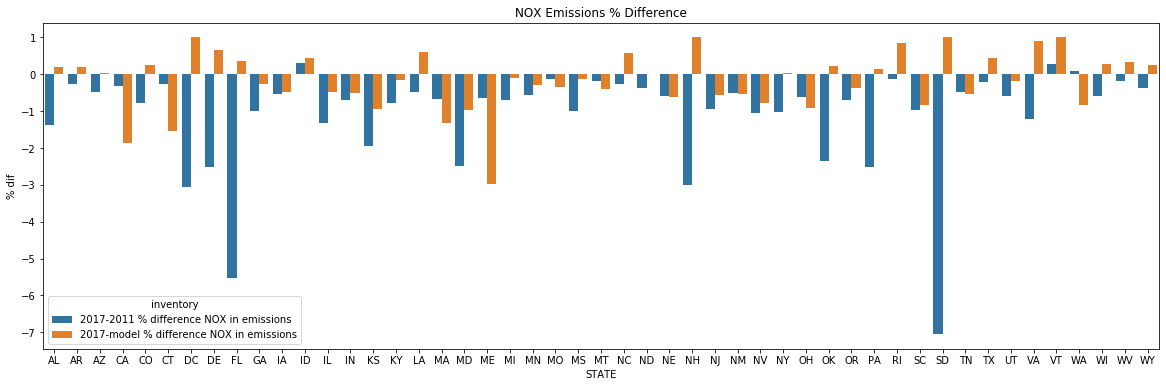

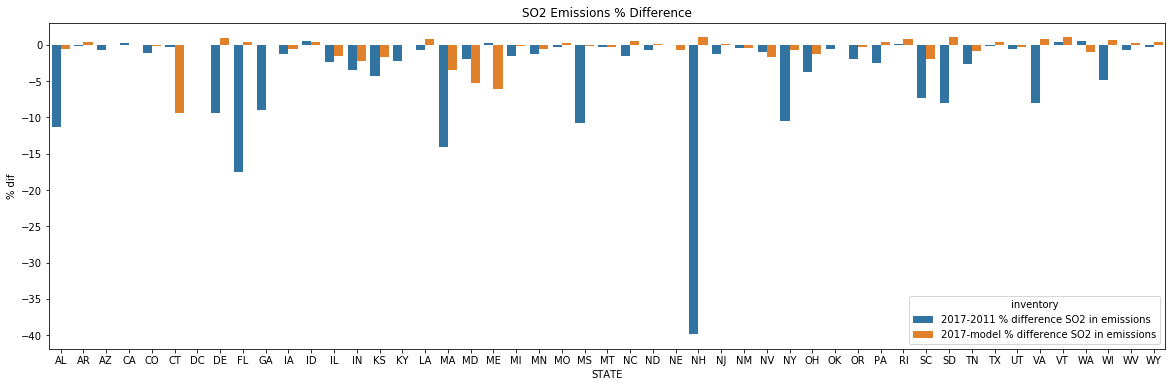

In [12]:
#plot our percent differences in emissions
for pollutant in pollutant_list:
    fig, ax = plt.subplots(figsize = [20,6])
    ax = sns.barplot(x = 'STATE', 
                     y = '% dif' , 
                     hue = 'inventory', 
                     data = df_dif_melted.loc[(df_dif_melted['inventory'] == f'2017-2011 % difference {pollutant} in emissions') 
                                          | (df_dif_melted['inventory'] == f'2017-model % difference {pollutant} in emissions')])
    plt.title(f'{pollutant} Emissions % Difference')
    plt.savefig(f'%dif_plot_{pollutant}.png', dpi = 100, bbox_inches = 'tight')

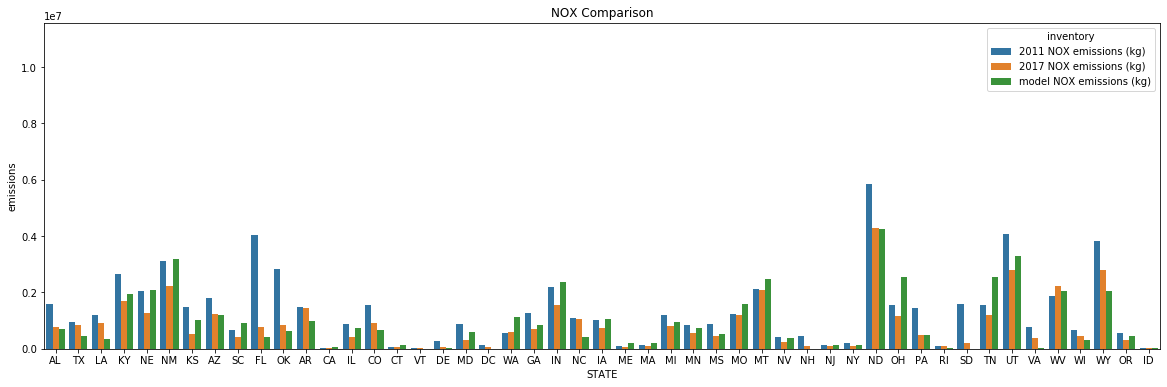

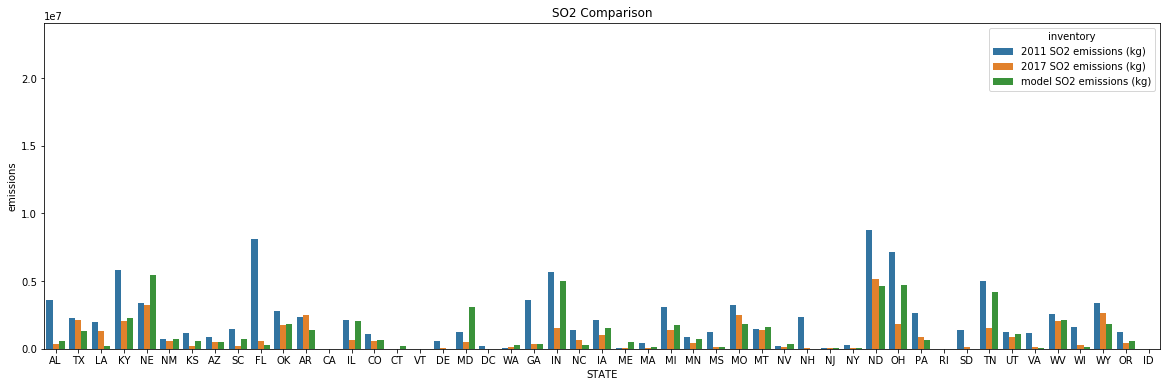

In [62]:
#plot our emissions in kg
for pollutant in pollutant_list:
    fig, ax = plt.subplots(figsize = [20,6])
    ax = sns.barplot(x = 'STATE', 
                     y = 'emissions' , 
                     hue = 'inventory', 
                     data = df_melted.loc[(df_melted['inventory'] == f'2011 {pollutant} emissions (kg)') | (df_melted['inventory'] == f'2017 {pollutant} emissions (kg)') | (df_melted['inventory'] == f'model {pollutant} emissions (kg)')], 
                     errwidth = 0)
    plt.title(f'{pollutant} Comparison')

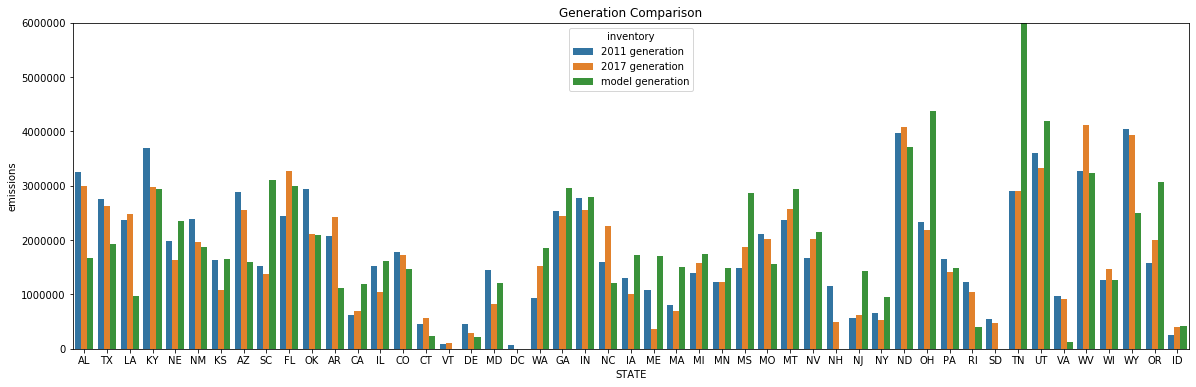

In [57]:
fig, ax = plt.subplots(figsize = [20,6])
df_melted = df_all.melt(id_vars = 'STATE', var_name = 'inventory',value_name='emissions')
ax = sns.barplot(x = 'STATE', 
                     y = 'emissions' , 
                     hue = 'inventory', 
                     data = df_melted.loc[(df_melted['inventory'] == f'2011 generation') | (df_melted['inventory'] == f'2017 generation') | (df_melted['inventory'] == f'model generation')], 
                     errwidth = 0)
plt.ylim(0, 0.6e7)
plt.title('Generation Comparison');

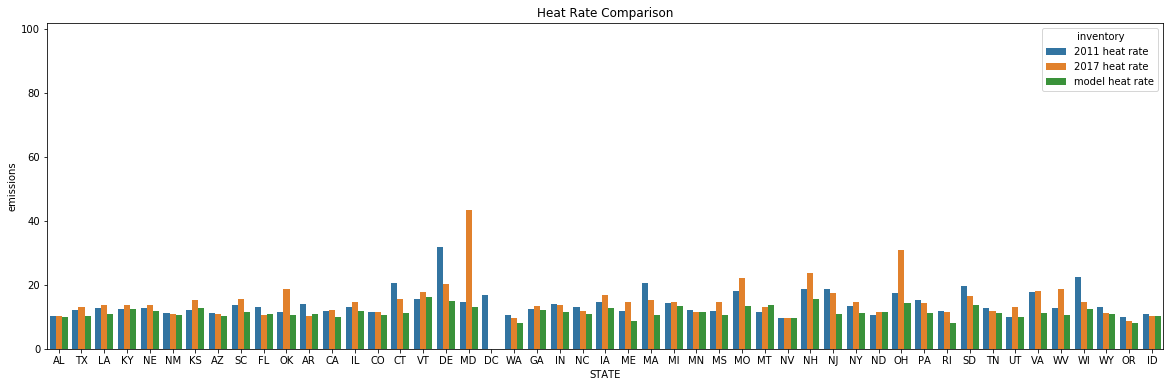

In [58]:
fig, ax = plt.subplots(figsize = [20,6])
df_melted = df_all.melt(id_vars = 'STATE', var_name = 'inventory',value_name='emissions')
ax = sns.barplot(x = 'STATE', 
                     y = 'emissions' , 
                     hue = 'inventory', 
                     data = df_melted.loc[(df_melted['inventory'] == f'2011 heat rate') | (df_melted['inventory'] == f'2017 heat rate') | (df_melted['inventory'] == f'model heat rate')], 
                     errwidth = 0)
#plt.ylim(0, 0.6e7)
plt.title('Heat Rate Comparison');



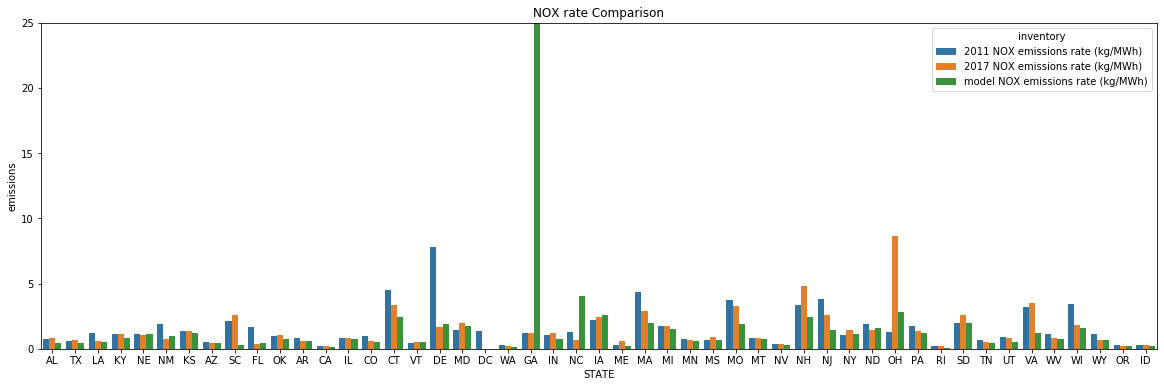

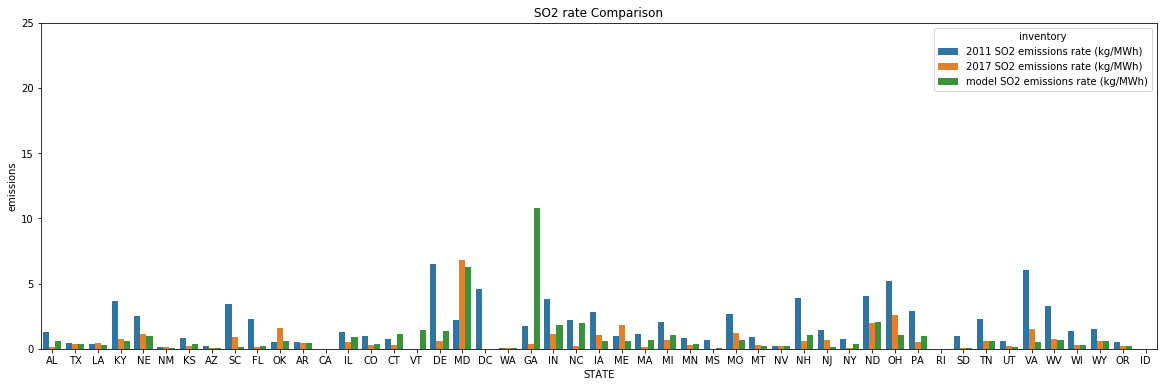

In [61]:
for pollutant in pollutant_list:
    fig, ax = plt.subplots(figsize = [20,6])
    ax = sns.barplot(x = 'STATE', 
                     y = 'emissions' , 
                     hue = 'inventory', 
                     data = df_melted.loc[(df_melted['inventory'] == f'2011 {pollutant} emissions rate (kg/MWh)') | (df_melted['inventory'] == f'2017 {pollutant} emissions rate (kg/MWh)') | (df_melted['inventory'] == f'model {pollutant} emissions rate (kg/MWh)')], 
                     errwidth = 0)
    plt.ylim(0, 25)
    plt.title(f'{pollutant} rate Comparison')